In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

In [8]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
import scarches as sca
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
from velovi import VELOVI


In [19]:
#Choose dataset
dataset = "pancreas"

#Choose model to train
model = "ivelo"

In [23]:
adata_file = "data/" + dataset + "/" + dataset + "_data_annotations.h5ad" #preprocessed data
adata_output = "data/" + dataset + "/" + dataset + "_data_output.h5ad" #path so save output adata after training model
metrics_dict = "output/" + dataset + "/" + model + "/latent_analysis.pkl"

### Hyperparameter optimization with W&B

In [12]:
import wandb
wandb.login()

/home/icb/cabright61/anaconda3/envs/thesis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/icb/cabright61/anaconda3/envs/thesis/lib/python3.8/site-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: chelseabright. Use `wandb login --relogin` to force relogin


True

In [ ]:
import scib
from pytorch_lightning.loggers import WandbLogger
#parser = argparse.ArgumentParser()

#parser.add_argument("adata_file", default="data/Pancreas/pancreas_data_annotations.h5ad")
#parser.add_argument("adata_output", default="data/Pancreas/pancreas_data_output.h5ad")

#args = parser.parse_args()

#adata_file = args.adata_file
#adata_output = args.adata_output

print(adata_file)

adata = sc.read(adata_file)

adata_train = adata.copy()
    
sweep_config = {
  "method": "bayes",  
  "metric": {           
      "name": "validation_loss",
      "goal": "minimize"
  },
  "parameters": {
        "n_layers": {
            # Choose from pre-defined values
            "values": [1,2,3]
        },

        "lr":  {'max': 0.01, 'min': 0.0001},
      
        "dropout_rate": {"values" : [0.1, 0.3, 0.5, 0.7]},
      
        "alpha_GP" : {"values" : [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1]},
      
        "alpha_kl" : {'max': 1.0, 'min': 0.01},

        "batch_size" : {"values" : [64, 128, 256]},

        
    },
    
    "early_terminate" : {"type": "hyperband", "min_iter": 20}
}

sweep_id = wandb.sweep(sweep_config, project="divelo")

def sweep_iteration():

    adata_train = adata.copy()

    wandb.init()    
    wandb_logger = WandbLogger()

    VELOVI.setup_anndata(adata_train, spliced_layer="Ms", unspliced_layer="Mu")

    omega_reactome=torch.ones(adata.varm["I"][:,50:].shape[1])
    omega_panglao=torch.zeros(adata.varm["I"][:,:50].shape[1])
    omega=torch.cat((omega_panglao,omega_reactome))

    vae = VELOVI(
        adata=adata_train,
        n_layers=wandb.config.n_layers,
        dropout_rate=wandb.config.dropout_rate,
        
        
    )

    trainer_kwargs={"logger": wandb_logger}

    vae.train(
        max_epochs=800,
        lr=wandb.config.lr,
        alpha_GP=wandb.config.alpha_GP,
        omega=omega,
        alpha_kl=wandb.config.alpha_kl,
        batch_size=wandb.config.batch_size,
        **trainer_kwargs
    )

    adata.obsm["latent"] = vae.get_latent()
    sc.pp.neighbors(adata, use_rep="latent")

    #calculate velocity confidence
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")
    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time
    scv.tl.velocity_graph(adata, n_jobs=10)
    scv.tl.velocity_confidence(adata)
    vel_conf=adata.obs["velocity_confidence"]
    
    scib.metrics.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="clusters")
    wandb.log({"mean vel conf": np.mean(vel_conf), "nmi": scib.metrics.nmi(adata, group1="cluster", group2="clusters"), 
              "ari": scib.me.ari(adata, group1="cluster", group2="clusters"), 
              "asw": scib.me.silhouette(adata, group_key="clusters", embed="latent"),
              "clust_avg" : (scib.metrics.nmi(adata, group1="cluster", group2="clusters")+scib.me.ari(adata, group1="cluster", group2="clusters")+scib.me.silhouette(adata, group_key="clusters", embed="latent"))/3,
              "metrics_avg" : (np.mean(vel_conf)+scib.metrics.nmi(adata, group1="cluster", group2="clusters")+scib.me.ari(adata, group1="cluster", group2="clusters")+scib.me.silhouette(adata, group_key="clusters", embed="latent"))/4
             })
    
    
wandb.agent(sweep_id, function=sweep_iteration, count=100)
wandb.finish()

### Train model with optimal hyperparameters

In [ ]:
adata = sc.read(adata_file)

adata_train = adata.copy()

config={ "alpha_GP" : 0.5,
        "alpha_kl" : 0.02,
        "batch_size" : 256,
        "dropout_rate" : 0.3,
        "lr" : 0.007,
        "n_layers" : 1,
        
       }
        

VELOVI.setup_anndata(adata_train, spliced_layer="Ms", unspliced_layer="Mu")

omega_reactome=torch.ones(adata.varm["I"][:,50:].shape[1])
omega_panglao=torch.zeros(adata.varm["I"][:,:50].shape[1])
omega=torch.cat((omega_panglao,omega_reactome))

vae = VELOVI(
    adata=adata_train,
    n_layers=config["n_layers"],
    dropout_rate=config["dropout_rate"],


)


vae.train(
    max_epochs=800,
    lr=config["lr"],
    alpha_GP=config["alpha_GP"],
    omega=omega,
    alpha_kl=config["alpha_kl"],
    batch_size=config["batch_size"],
)

adata.obsm["X_" + model + "_opt_all"] = vae.get_latent()
adata.obsm["X_" + model + "_opt_active"] = vae.get_latent(only_active=True)

adata.write(adata_output)


In [6]:
adata_output = "data/" + dataset + "/" + dataset + "_data_output.h5ad" #path of output adata after training model
adata = sc.read(adata_output)

In [ ]:
sc.pp.neighbors(adata, use_rep="X_" + model + "_opt_all")
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters', frameon=False, save="_" + model + "_opt_all.png")

sc.pp.neighbors(adata, use_rep="X_" + model + "_opt_active")
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters', frameon=False, save="_" + model + "_opt_active.png")

In [8]:
#Load model
vae=VELOVI.load("trained_models/" + dataset + "/" + model, adata)

INFO     File trained_models/pancreas/divelo/model.pt already downloaded                     
Last Decoder layer: softmax


In [15]:
#calculate velocity confidence
latent_time = vae.get_latent_time(n_samples=25)
velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")
t = latent_time
scaling = 20 / t.max(0)

adata.layers["velocity"] = velocities / scaling
adata.layers["latent_time_velovi"] = latent_time
scv.tl.velocity_graph(adata, n_jobs=10)
scv.tl.velocity_confidence(adata)
vel_conf=adata.obs["velocity_confidence"]

computing velocity graph (using 10/96 cores)


  0%|          | 0/3756 [00:00<?, ?cells/s]

    finished (0:03:22) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [16]:
import scib

scib.metrics.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="clusters")
print(f"nmi: {scib.metrics.nmi(adata, group1='cluster', group2='clusters')}")
print(f"ari: {scib.me.ari(adata, group1='cluster', group2='clusters')}")
print(f"asw: {scib.me.silhouette(adata, group_key='clusters', embed='X_' + model + '_opt_active')}")
print(f"cluster avg: {(scib.metrics.nmi(adata, group1='cluster', group2='clusters')+scib.me.ari(adata, group1='cluster', group2='clusters')+scib.me.silhouette(adata, group_key='clusters', embed='X_' + model + '_opt_active'))/3}")
print(f"metrics avg: {(np.mean(vel_conf)+scib.metrics.nmi(adata, group1='cluster', group2='clusters')+scib.me.ari(adata, group1='cluster', group2='clusters')+scib.me.silhouette(adata, group_key='clusters', embed='X_' + model + '_opt_active'))/4}")

resolution: 0.1, nmi: 0.4502814370174928
resolution: 0.2, nmi: 0.5740532716827245
resolution: 0.3, nmi: 0.6103738436548771
resolution: 0.4, nmi: 0.602628615084183
resolution: 0.5, nmi: 0.6521560510899418
resolution: 0.6, nmi: 0.6578473906621656
resolution: 0.7, nmi: 0.7294776531787256
resolution: 0.8, nmi: 0.7103646219378769
resolution: 0.9, nmi: 0.6965821498155189
resolution: 1.0, nmi: 0.7061979486686712
resolution: 1.1, nmi: 0.6979737409280525
resolution: 1.2, nmi: 0.6972437509159229
resolution: 1.3, nmi: 0.692291538099322
resolution: 1.4, nmi: 0.6863360223407989
resolution: 1.5, nmi: 0.6769745497979893
resolution: 1.6, nmi: 0.6518231298206907
resolution: 1.7, nmi: 0.6616311991229988
resolution: 1.8, nmi: 0.6551046082412073
resolution: 1.9, nmi: 0.6560584668494951
resolution: 2.0, nmi: 0.6560390750389745
optimised clustering against clusters
optimal cluster resolution: 0.7
optimal score: 0.7294776531787256
nmi: 0.7294776531787257
ari: 0.6760001081325137


<ipython-input-16-411f0f70a643>:4: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version.
  print(f"nmi: {scib.metrics.nmi(adata, group1='cluster', group2='clusters')}")
<ipython-input-16-411f0f70a643>:4: DeprecationWarning: Keyword argument 'group2' has been deprecated in favour of 'label_key'. 'group2' will be removed in a future version.
  print(f"nmi: {scib.metrics.nmi(adata, group1='cluster', group2='clusters')}")
<ipython-input-16-411f0f70a643>:5: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version.
  print(f"ari: {scib.me.ari(adata, group1='cluster', group2='clusters')}")
<ipython-input-16-411f0f70a643>:5: DeprecationWarning: Keyword argument 'group2' has been deprecated in favour of 'label_key'. 'group2' will be removed in a future version.
  print(f"ari: {scib.me.ari(adata, group1='cluster', group2='clusters

asw: 0.5071631828323007
cluster avg: 0.6375469813811799


<ipython-input-16-411f0f70a643>:7: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version.
  print(f"cluster avg: {(scib.metrics.nmi(adata, group1='cluster', group2='clusters')+scib.me.ari(adata, group1='cluster', group2='clusters')+scib.me.silhouette(adata, group_key='clusters', embed='X_' + model + '_opt_active'))/3}")
<ipython-input-16-411f0f70a643>:7: DeprecationWarning: Keyword argument 'group2' has been deprecated in favour of 'label_key'. 'group2' will be removed in a future version.
  print(f"cluster avg: {(scib.metrics.nmi(adata, group1='cluster', group2='clusters')+scib.me.ari(adata, group1='cluster', group2='clusters')+scib.me.silhouette(adata, group_key='clusters', embed='X_' + model + '_opt_active'))/3}")
<ipython-input-16-411f0f70a643>:7: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version.
  print(f"clu

metrics avg: 0.6731502493582684


<ipython-input-16-411f0f70a643>:8: DeprecationWarning: Keyword argument 'group_key' has been deprecated in favour of 'label_key'. 'group_key' will be removed in a future version.
  print(f"metrics avg: {(np.mean(vel_conf)+scib.metrics.nmi(adata, group1='cluster', group2='clusters')+scib.me.ari(adata, group1='cluster', group2='clusters')+scib.me.silhouette(adata, group_key='clusters', embed='X_' + model + '_opt_active'))/4}")


In [17]:
#make dictionary of metrics for plotting
metrics={}
metrics["nmi"] = scib.me.nmi(adata, group1="cluster", group2="clusters")
metrics["ari"] = scib.me.ari(adata, group1="cluster", group2="clusters")
metrics["asw"] = scib.me.silhouette(adata, group_key="clusters", embed="X_" + model + "_opt_active")
metrics["clust_avg"] = (scib.metrics.nmi(adata, group1="cluster", group2="clusters")+scib.me.ari(adata, group1="cluster", group2="clusters")+scib.me.silhouette(adata, group_key="clusters", embed="X_" + model + "_opt_active"))/3,
metrics["metrics_avg"] = (np.mean(vel_conf)+scib.metrics.nmi(adata, group1="cluster", group2="clusters")+scib.me.ari(adata, group1="cluster", group2="clusters")+scib.me.silhouette(adata, group_key="clusters", embed="X_" + model + "_opt_active"))/4

/home/icb/cabright61/anaconda3/envs/thesis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-17-a076296ed01a>:3: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'cluster_key'. 'group1' will be removed in a future version.
  metrics["nmi"] = scib.me.nmi(adata, group1="cluster", group2="clusters")
<ipython-input-17-a076296ed01a>:3: DeprecationWarning: Keyword argument 'group2' has been deprecated in favour of 'label_key'. 'group2' will be removed in a future version.
  metrics["nmi"] = scib.me.nmi(adata, group1="cluster", group2="clusters")
<ipython-input-17-a076296ed01a>:4: DeprecationWarning: Keyword argument 'group1' has been deprecated in favour of 'c

In [24]:
#save dictionary to pkl
import pickle
with open(metrics_dict, 'wb') as f:
    pickle.dump(metrics, f)

In [26]:
vae.save("trained_models/" + dataset + "/" + model) 

### Save latent enrich results to dictionary

In [12]:
import collections
top_gps_per_cell = collections.defaultdict(dict)
for cell_type in adata.uns["bf_scores"].keys():
    mask=abs(adata.uns["bf_scores"][cell_type]["bf"])>=2.3
    GP_index=np.arange(len(active_terms))
    sig_GP_index=list(compress(GP_index, mask))
    top_gps_per_cell[cell_type]["terms"] = np.array(active_terms)[sig_GP_index]
    top_gps_per_cell[cell_type]["terms"] = np.array(active_terms)[sig_GP_index]
    top_gps_per_cell[cell_type]["bf_scores"] = adata.uns["bf_scores"][cell_type]["bf"]
    top_gps_per_cell[cell_type]["bf_scores_sig"] = adata.uns["bf_scores"][cell_type]["bf"][mask]
    top_gps_per_cell[cell_type]["sig_GP_index"] = sig_GP_index

In [13]:
import collections

#add active terms and bf_scores into df

top_n_terms=[]
for cell_type in adata.uns["bf_scores"].keys():
    bf_scores=adata.uns["bf_scores"][cell_type]["bf"]
    d = {'active_terms': active_terms, 'bf_scores': bf_scores}
    df=pd.DataFrame(data=d, columns=["active_terms", "bf_scores"])
    top_n_df=df.sort_values(by=["bf_scores"], ascending=False)[:10]
    top_n_terms.extend(top_n_df["active_terms"])

top_n_terms = list(set(top_n_terms)) #100

In [25]:
#from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

acc=[]
idx = [active_terms.index(term) for term in top_n_terms]
directions=adata.uns["directions"]
directions=directions[directions!=0]
latents = (adata.obsm["X_" + model + "_opt_active"]*directions)[:, idx]
labels=pd.Categorical(adata.obs["clusters"]).codes
#for i in range(latents.shape[1]):
#    X_train, X_test, y_train, y_test = train_test_split(latents[:,i].reshape(-1, 1), labels, test_size=.2)
#    clf = GradientBoostingClassifier().fit(latents[:,i].reshape(-1, 1), labels)
#    pred=clf.predict(latents[:,i].reshape(-1, 1))
#    acc.append(clf.score(latents[:,i].reshape(-1, 1), labels))

X_train, X_test, y_train, y_test = train_test_split(latents, labels, test_size=0.2)
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

def fit(x):
    params = {'objective':'multi:softmax',
              'num_class': len(list(set(labels))),
              'learning_rate':int(x[0]),
              #'colsample_bytree':int(x[1]),
              #'learning_rate':0.1,
              'min_child_weight':1,
              'max_depth':5,
             
             }
    xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, early_stopping_rounds=50,
    nfold=5, seed=42)
    return xgb_cv[-1:].values[0]

grid = pd.DataFrame({'learning_rate':[0.01, 0.05, 0.1], 
                     #'colsample_bytree':np.repeat([0.6,0.7,0.8,0.9],4), 
                     #'min_child_weight':np.repeat([1,2,3],3)
                     #'learning_rate':np.repeat([0.01,0.05,0.1],3),
                     #'subsample':np.repeat([0.1,0.3],3)
                    })

grid[['train-mean','train-std',
'test-mean','test-std']] = grid.apply(fit,axis=1,result_type='expand')


In [26]:
grid

learning_rate  train-mean  train-std  test-mean  test-std
0           0.01    2.397895        0.0   2.397895       0.0
1           0.05    2.397895        0.0   2.397895       0.0
2           0.10    2.397895        0.0   2.397895       0.0

In [28]:
clf = XGBClassifier(objective='multi:softmax',
                           learning_rate = 0.1,
                           min_child_weight = 1,
                           max_depth = 5,
                   
                   )

clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(accuracy)
top_gps_per_cell["XGB_acc"] = accuracy

0.9082446808510638


In [29]:
#save dictionary to pkl
import pickle
with open('output/' + dataset + '/' + model + '/GP_analysis.pkl', 'wb') as f:
    pickle.dump(top_gps_per_cell, f)

Plot latent space to visualize gene programs

In [18]:
#get latent directions
vae.latent_directions()

In [19]:
terms = adata.uns['terms']
terms

['ALPHA_CELLS',
 'BETA_CELLS',
 'DELTA_CELLS',
 'ENDOTHELIAL_CELLS',
 'ENTEROENDOCRINE_CELLS',
 'EPITHELIAL_CELLS',
 'FIBROBLASTS',
 'HEPATOCYTES',
 'INTERNEURONS',
 'MAST_CELLS',
 'NEUROBLASTS',
 'NEURONS',
 'PURKINJE_NEURONS',
 'SIGNALLING_BY_NGF',
 'DEVELOPMENTAL_BIOLOGY',
 'CELL_CYCLE',
 'GASTRIN_CREB_SIGNALLING_PATHWA',
 'TRANSMISSION_ACROSS_CHEMICAL_S',
 'NEURONAL_SYSTEM',
 'SIGNALING_BY_GPCR',
 'CLASS_A1_RHODOPSIN_LIKE_RECEPT',
 'INTEGRATION_OF_ENERGY_METABOLI',
 'CELL_CYCLE_MITOTIC',
 'NEUROTRANSMITTER_RECEPTOR_BIND',
 'CELL_CYCLE_CHECKPOINTS',
 'DIABETES_PATHWAYS',
 'TRANSMEMBRANE_TRANSPORT_OF_SMA',
 'METABOLISM_OF_PROTEINS',
 'G1_S_TRANSITION',
 'AXON_GUIDANCE',
 'REGULATION_OF_INSULIN_SECRETIO',
 'SLC_MEDIATED_TRANSMEMBRANE_TRA',
 'GPCR_DOWNSTREAM_SIGNALING',
 'G_ALPHA_I_SIGNALLING_EVENTS',
 'G_ALPHA_S_SIGNALLING_EVENTS',
 'SYNTHESIS_OF_DNA',
 'MITOTIC_G1_G1_S_PHASES',
 'MITOTIC_M_M_G1_PHASES',
 'GPCR_LIGAND_BINDING',
 'CHROMOSOME_MAINTENANCE',
 'METABOLISM_OF_LIPIDS_AND_LIP

In [20]:
select_terms = ['CELL_CYCLE', 'DEVELOPMENTAL_BIOLOGY',]
idx = [terms.index(term) for term in select_terms]

In [21]:
latents = (adata.obsm["latent"]*adata.uns['directions'])[:, idx]

In [22]:
adata.obs['CELL_CYCLE'] = latents[:, 0]
adata.obs['DEVELOPMENTAL_BIOLOGY'] = latents[:, 1]

#sc.pl.scatter(adata, x='CLASS_A1_RHODOPSIN_LIKE_RECEPT', y='CHROMOSOME_MAINTENANCE', color='clusters', groups="Epsilon", size=10)#, save="2.png")

Umap of GPs

/home/chels/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:452: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(


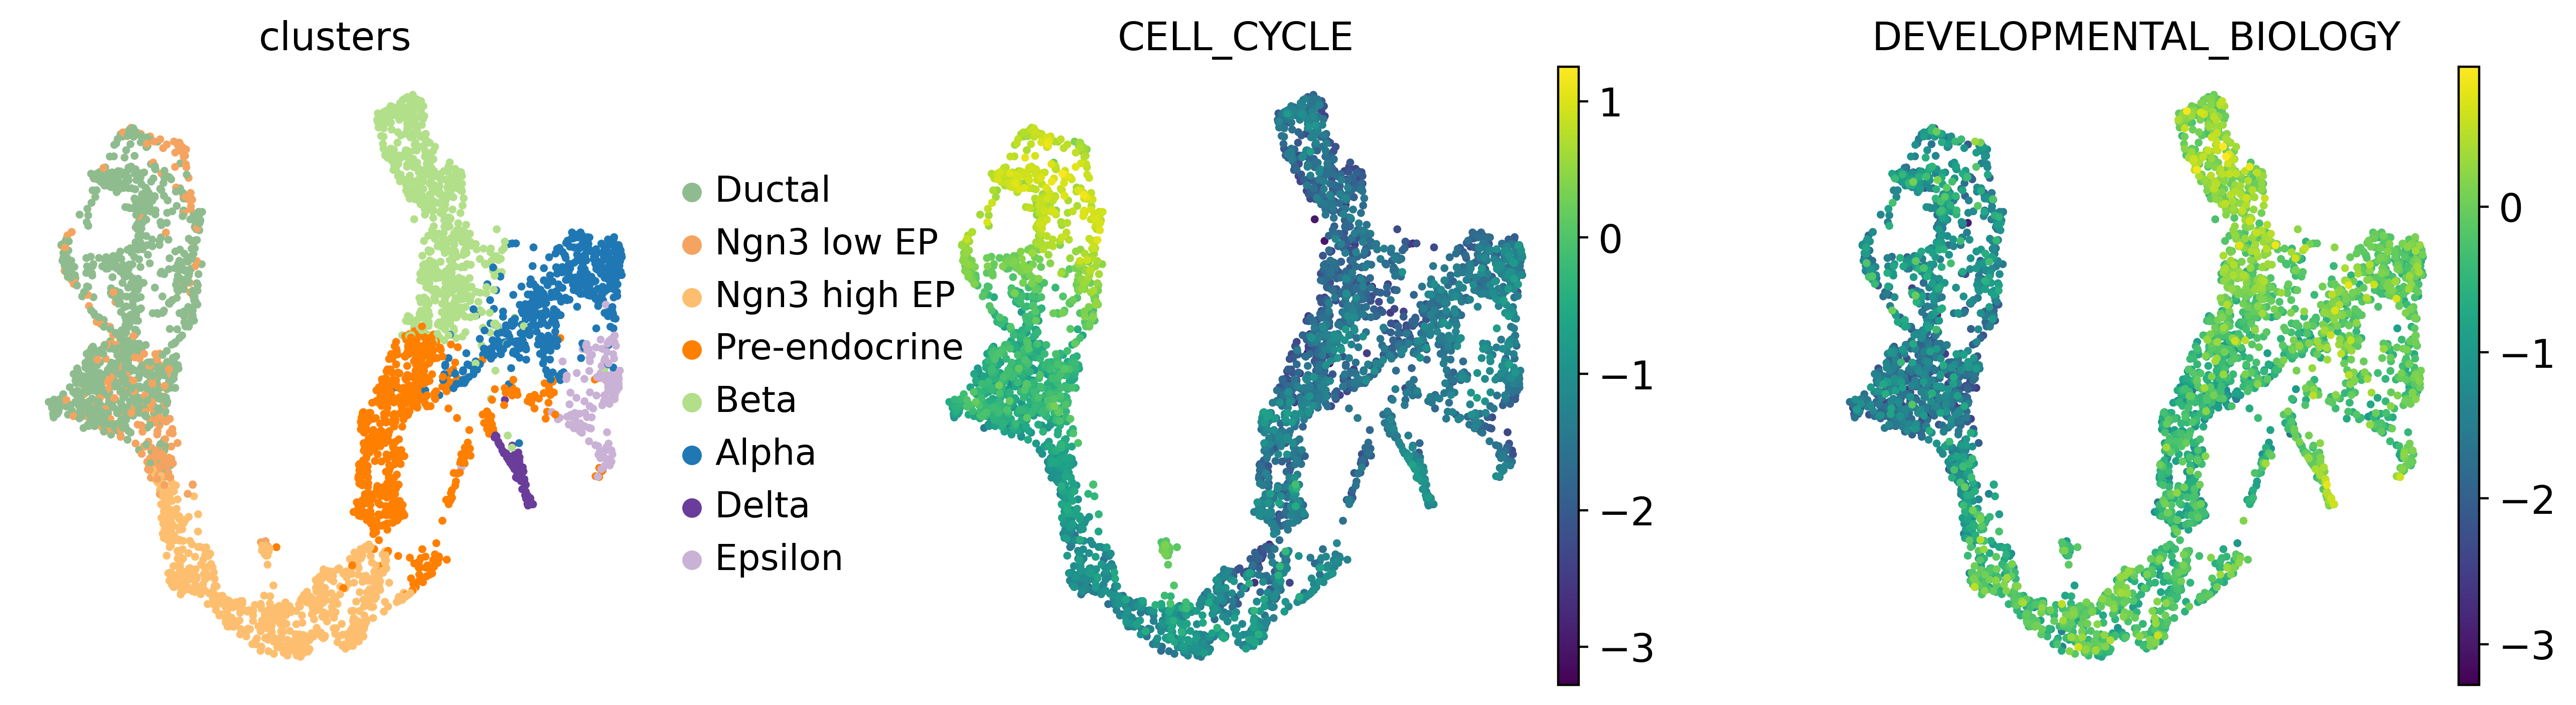

In [23]:
sc.pl.umap(adata, color=['clusters', 'CELL_CYCLE', "DEVELOPMENTAL_BIOLOGY"], frameon=False, wspace=0.3)

Get genes for each term ranked by absolute weight in decoder

In [157]:
terms=["SIGNALING_BY_GPCR","CELL_CYCLE", "NEURONAL_SYSTEM","GPCR_DOWNSTREAM_SIGNALING","ADAPTIVE_IMMUNE_SYSTEM","MITOTIC_PROMETAPHASE", "G_ALPHA_I_SIGNALLING_EVENTS", "DIABETES_PATHWAYS","GPCR_LIGAND_BINDING","CLASS_A1_RHODOPSIN_LIKE_RECEPT","CHROMOSOME_MAINTENANCE"]
for term in terms:
    df=vae.term_genes(term)
    df.to_csv(f"output/ranked_genes_{term}.csv")


### Analysis of saved model

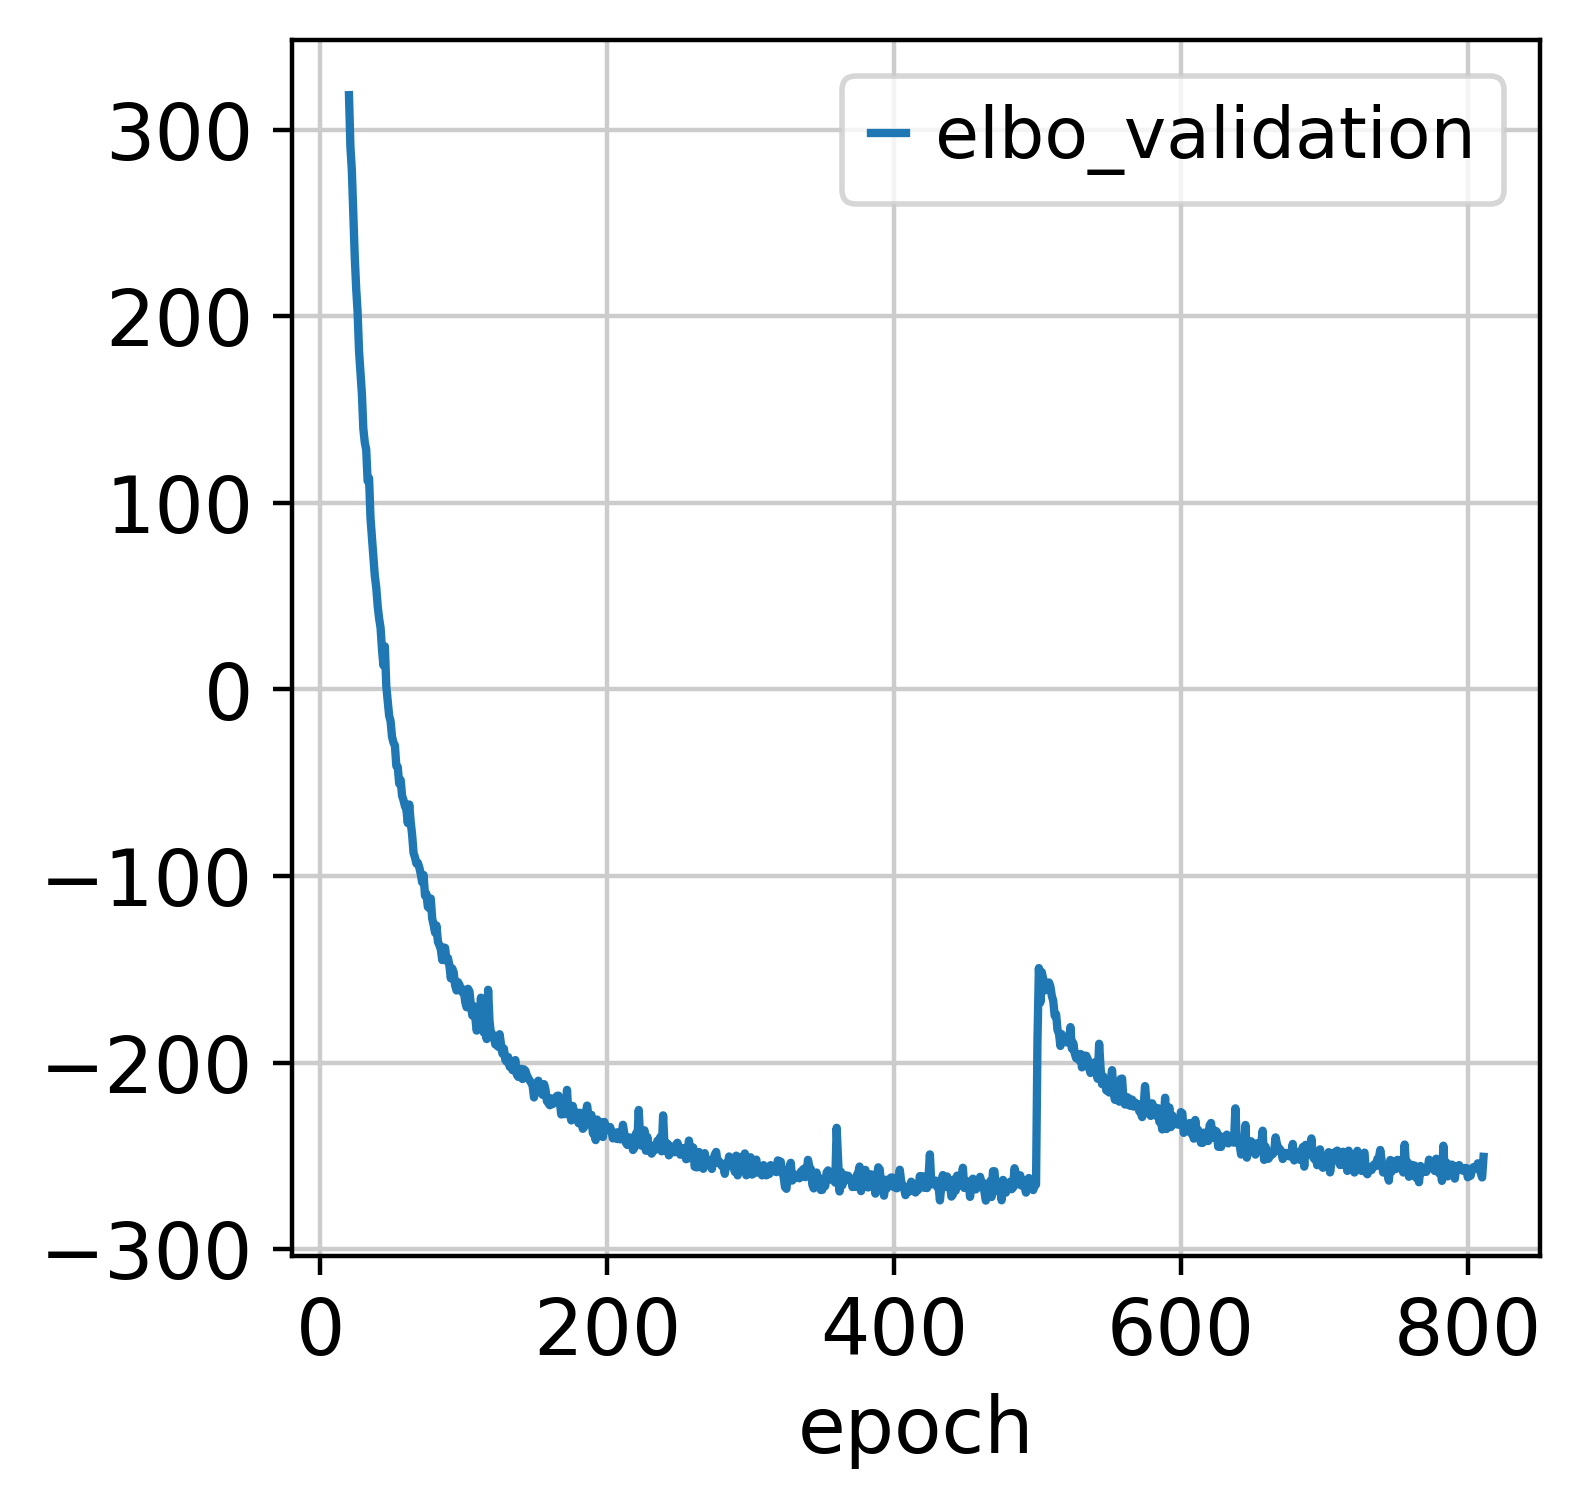

In [24]:
fig, ax = plt.subplots()
#vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

Compare model to velovi

In [25]:
#Compare the MSE for unspliced and spliced counts between Velo_interpret and original 

import pandas as pd
pred=vae.get_expression_fit()
pred_s=pred[0]
pred_u=pred[1]
GT_s=adata.layers["Ms"]
GT_u=adata.layers["Mu"]
MSE_s=np.mean((pred_s-GT_s)**2, axis=0)
MSE_u=np.mean((pred_u-GT_u)**2, axis=0)

ivelo_MSE=pd.DataFrame([MSE_s,MSE_u]).T

ivelo_MSE.to_csv("MSE_ivelo.csv")

# #Read in saved MSE from velovi_orig
# velo_orig_MSE=pd.read_csv("MSE_velovi_orig.csv", index_col="index")

# #Calculate log10 MSE ratios
# log10MSE_s=np.log10(velo_orig_MSE["0"]/velo_interpret_MSE[0])
# log10MSE_u=np.log10(velo_orig_MSE["1"]/velo_interpret_MSE[1])
# log10MSE_s=log10MSE_s.dropna()
# log10MSE_u=log10MSE_u.dropna()

# #Combine MSE for spliced and unspliced into 1 dataframe
# MSE_combined=pd.DataFrame([log10MSE_s,log10MSE_u]).T
# MSE_combined=MSE_combined.rename(columns={0:"spliced",1:"unspliced"})

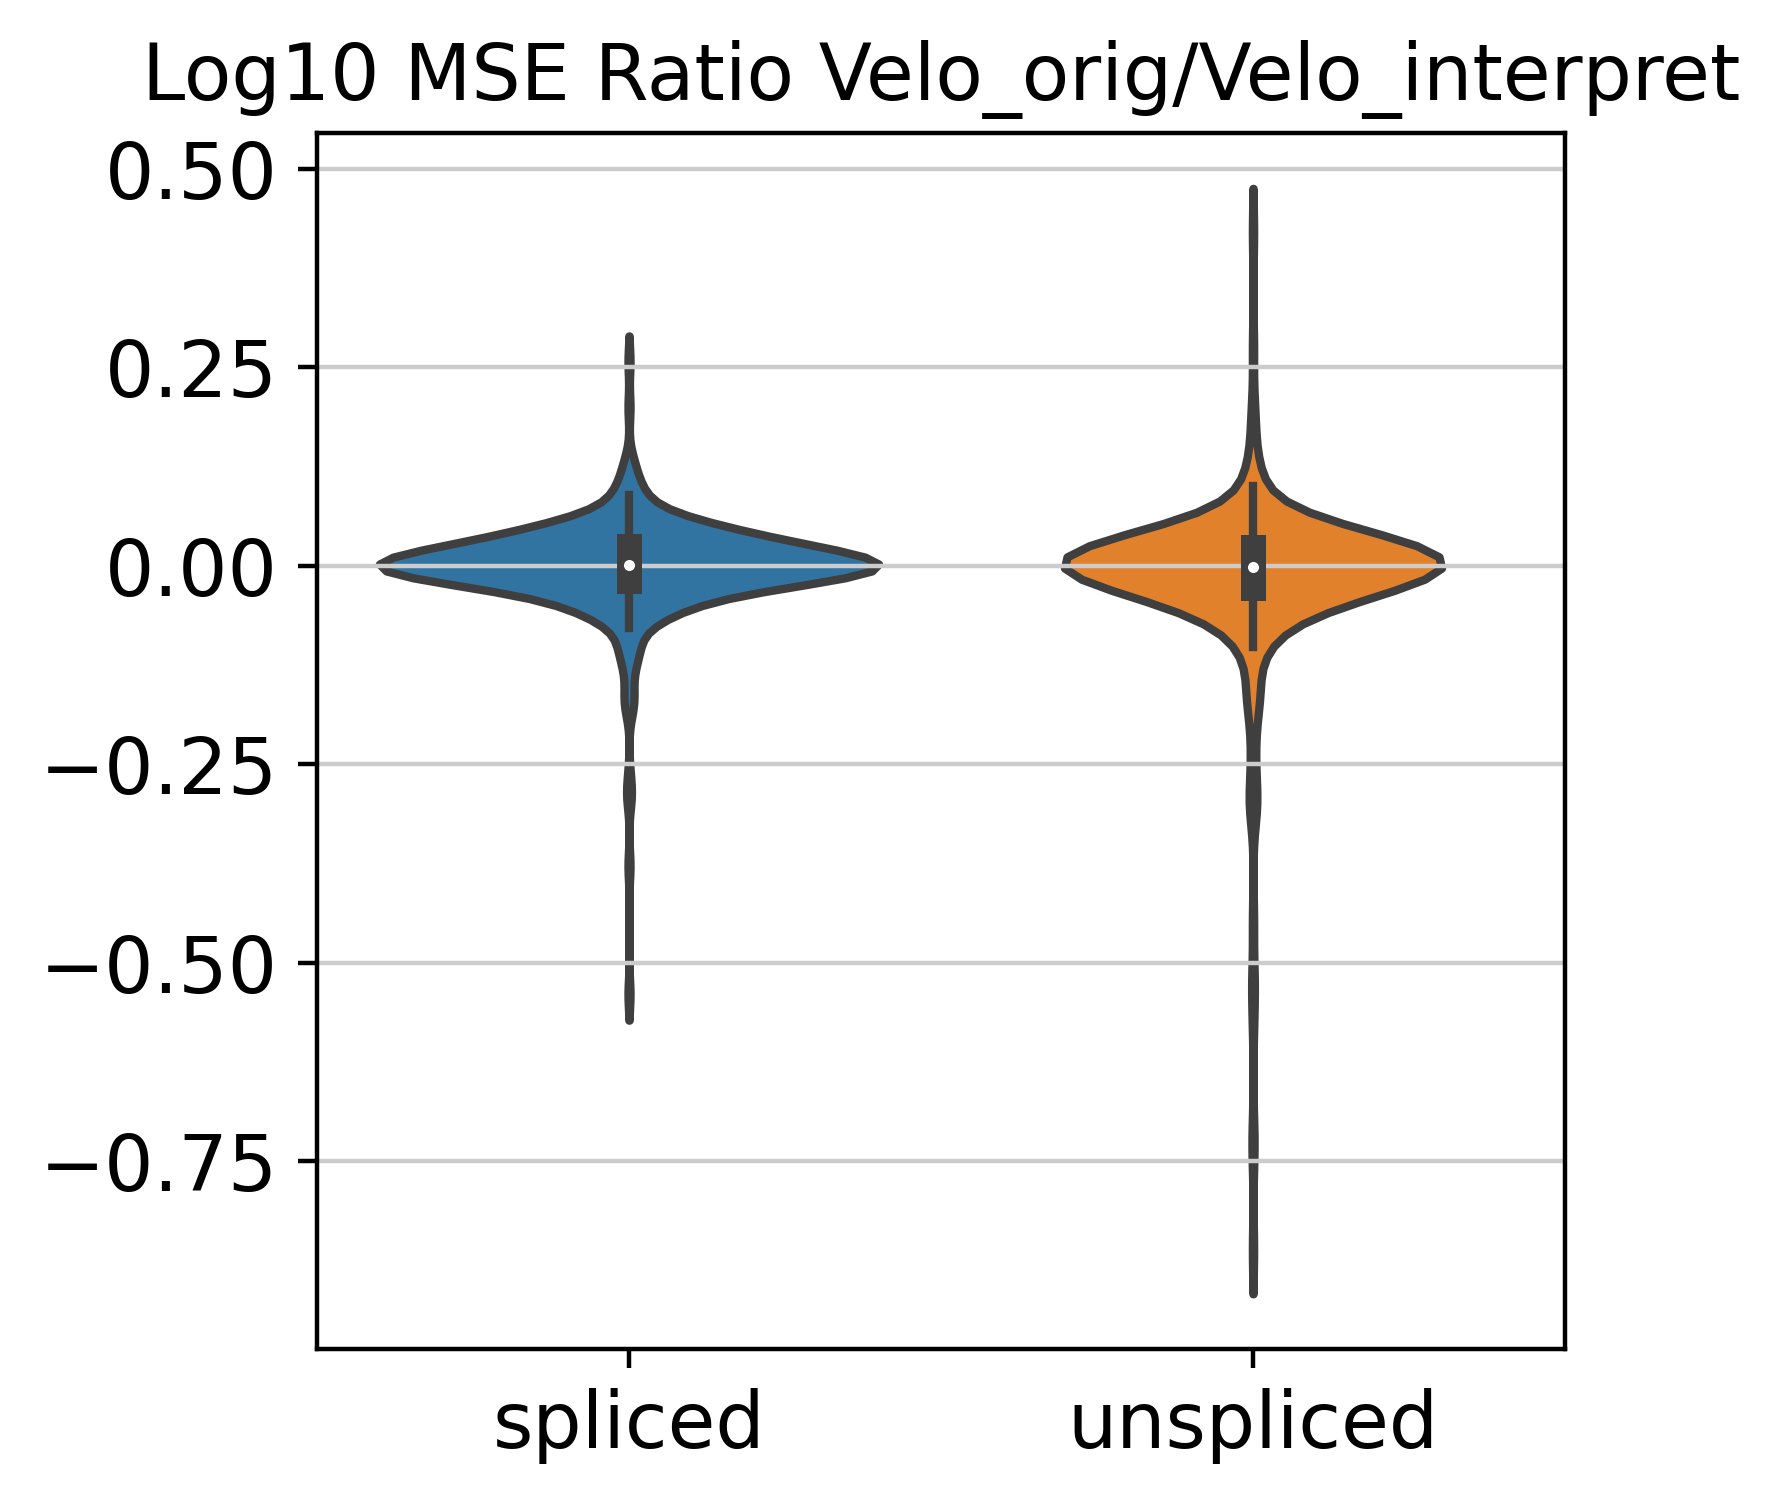

In [51]:
#Get violin plot of log10 MSEs
ax=sns.violinplot(data=MSE_combined)
ax.set_title("Log10 MSE Ratio Velo_orig/Velo_interpret")
MSE_fig=ax.get_figure()
#MSE_fig.savefig("figures/decoder2/log10MSE.png") 

Add outputs of velo_interpret to adata

In [25]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [27]:
#get velocity confidence 
scv.tl.velocity_graph(adata)
scv.tl.velocity_confidence(adata)

computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [ ]:
#save velocity confidene results
velo_int_s_vc=pd.DataFrame(adata.obs["velocity_confidence"])
velo_int_s_vc.to_csv("vel_conf_Velo_Int_S.csv")

In [46]:
velo_orig_vc=pd.read_csv("vel_conf_veloVI.csv", index_col="index")
velo_orig_vc=velo_orig_vc.rename(columns={"velocity_confidence":"vc_veloVI"})
scvelo_vc=pd.read_csv("vel_conf_scVelo.csv", index_col="index")
scvelo_vc=scvelo_vc.rename(columns={"velocity_confidence":"vc_scvelo"})
# velo_int_s_vc=pd.read_csv("vel_conf_Velo_Int_S.csv", index_col="index")
# velo_int_s_vc=velo_int_s_vc.rename(columns={"velocity_confidence":"vc_velo_interpret_single"})
velo_int_d_vc=pd.DataFrame(adata.obs["velocity_confidence"])
velo_int_d_vc=velo_int_d_vc.rename(columns={"velocity_confidence":"vc_velo_interpret_single"})

In [47]:
vc_combined=pd.concat([scvelo_vc,velo_orig_vc,velo_int_d_vc],axis=1)

In [48]:
vc_combined

vc_scvelo  vc_veloVI  vc_velo_interpret_single
index                                                           
AAACCTGAGAGGGATA   0.769216   0.900101                  0.896680
AAACCTGAGCCTTGAT   0.792310   0.910085                  0.897434
AAACCTGAGGCAATTA   0.733762   0.840806                  0.873588
AAACCTGCATCATCCC   0.746999   0.881598                  0.905368
AAACCTGGTAAGTGGC   0.775375   0.905970                  0.911187
...                     ...        ...                       ...
TTTGTCAAGTGACATA   0.589383   0.853201                  0.861832
TTTGTCAAGTGTGGCA   0.717359   0.838502                  0.834472
TTTGTCAGTTGTTTGG   0.657952   0.858520                  0.820456
TTTGTCATCGAATGCT   0.809008   0.901181                  0.900746
TTTGTCATCTGTTTGT   0.704007   0.833331                  0.858083

[3696 rows x 3 columns]

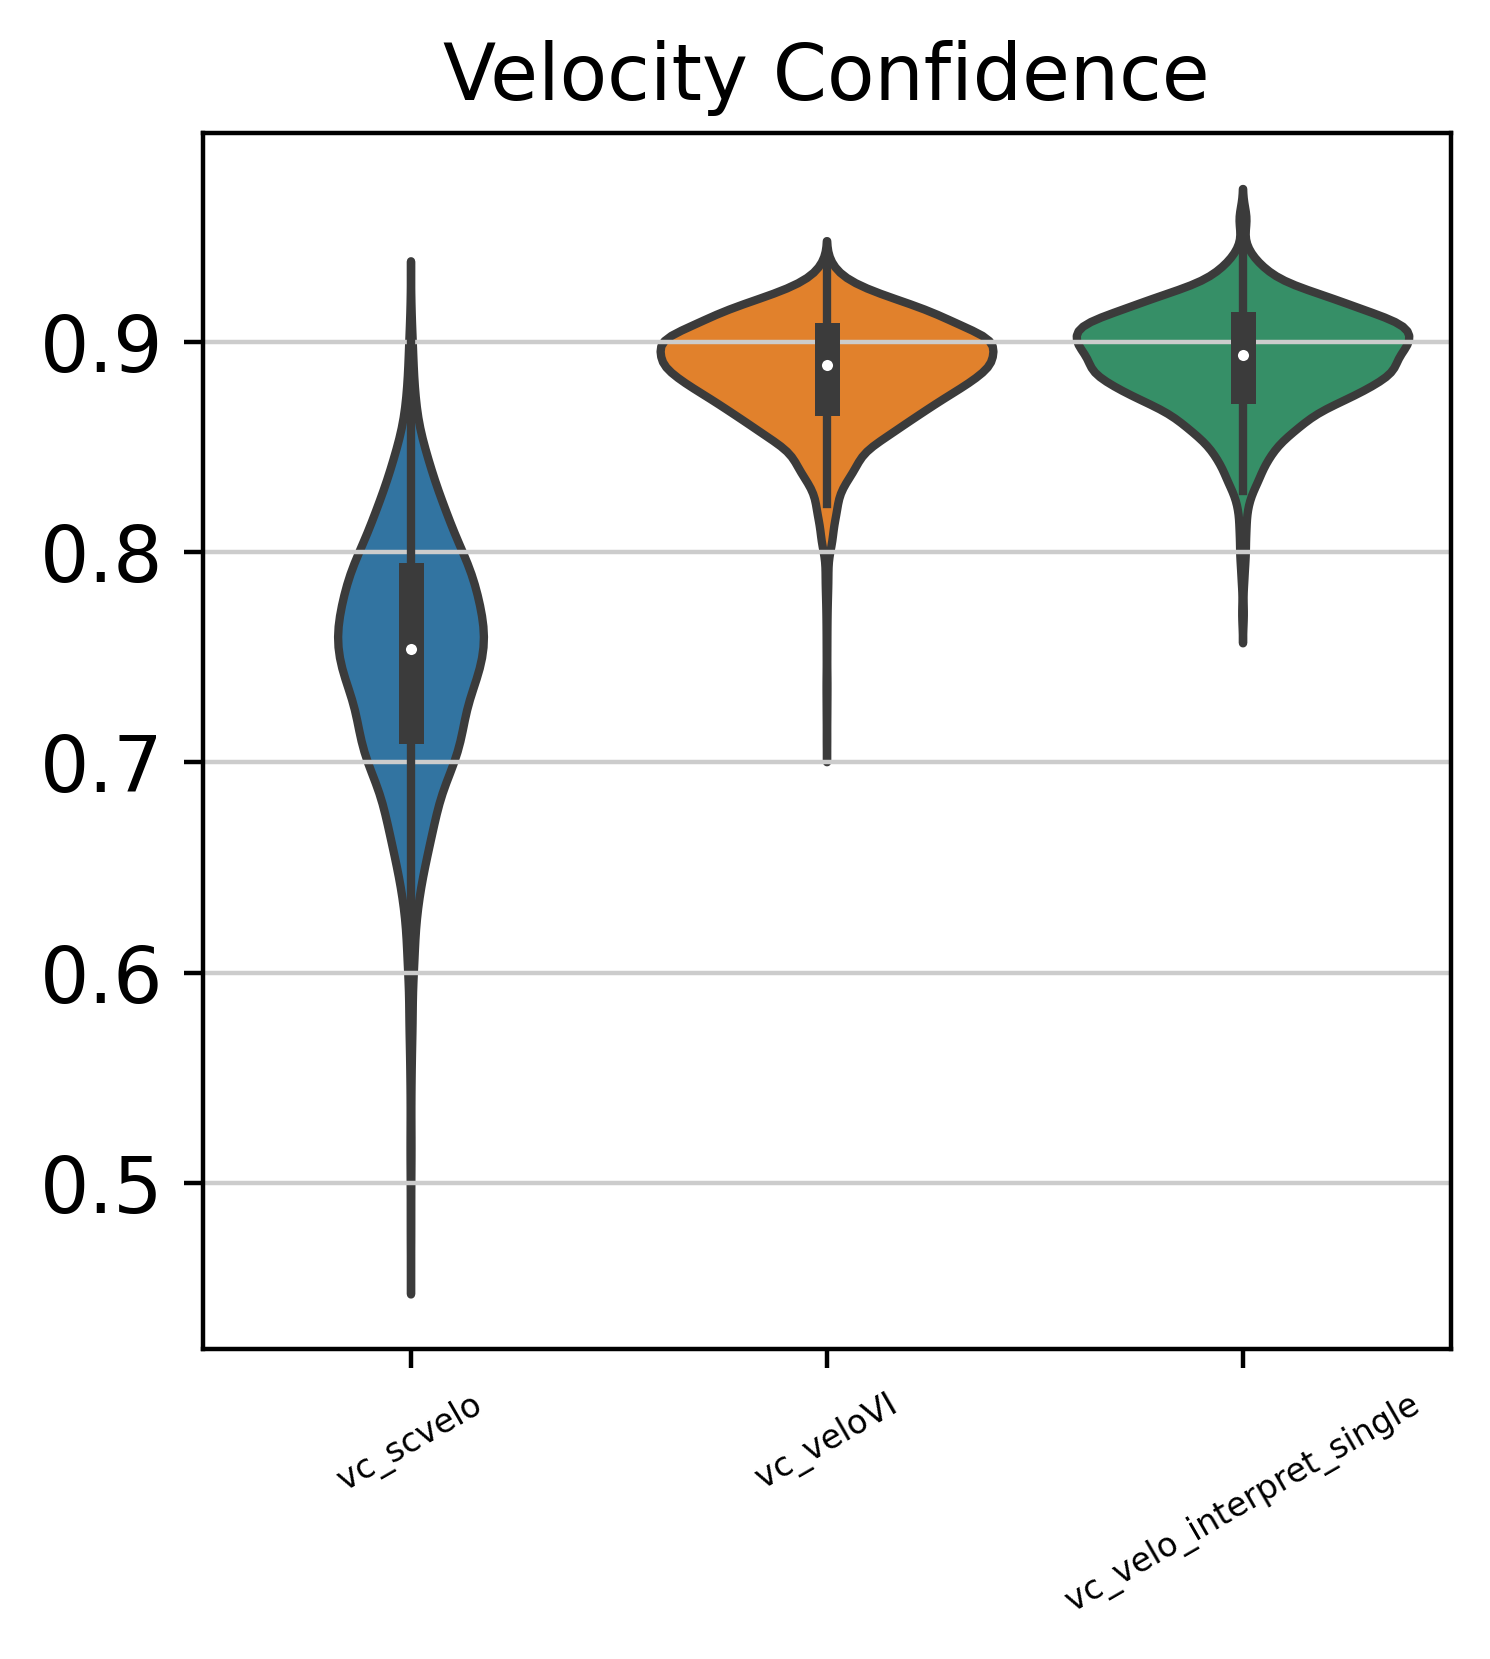

In [49]:
#Get violin plot of velocity confidence
ax=sns.violinplot(data=vc_combined)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, size = 6)
ax.set_title("Velocity Confidence")
fig=ax.get_figure()
#fig.savefig("figures/vel_conf.png") 

Get Velocity graph

In [26]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_velocity_embedding.pdf


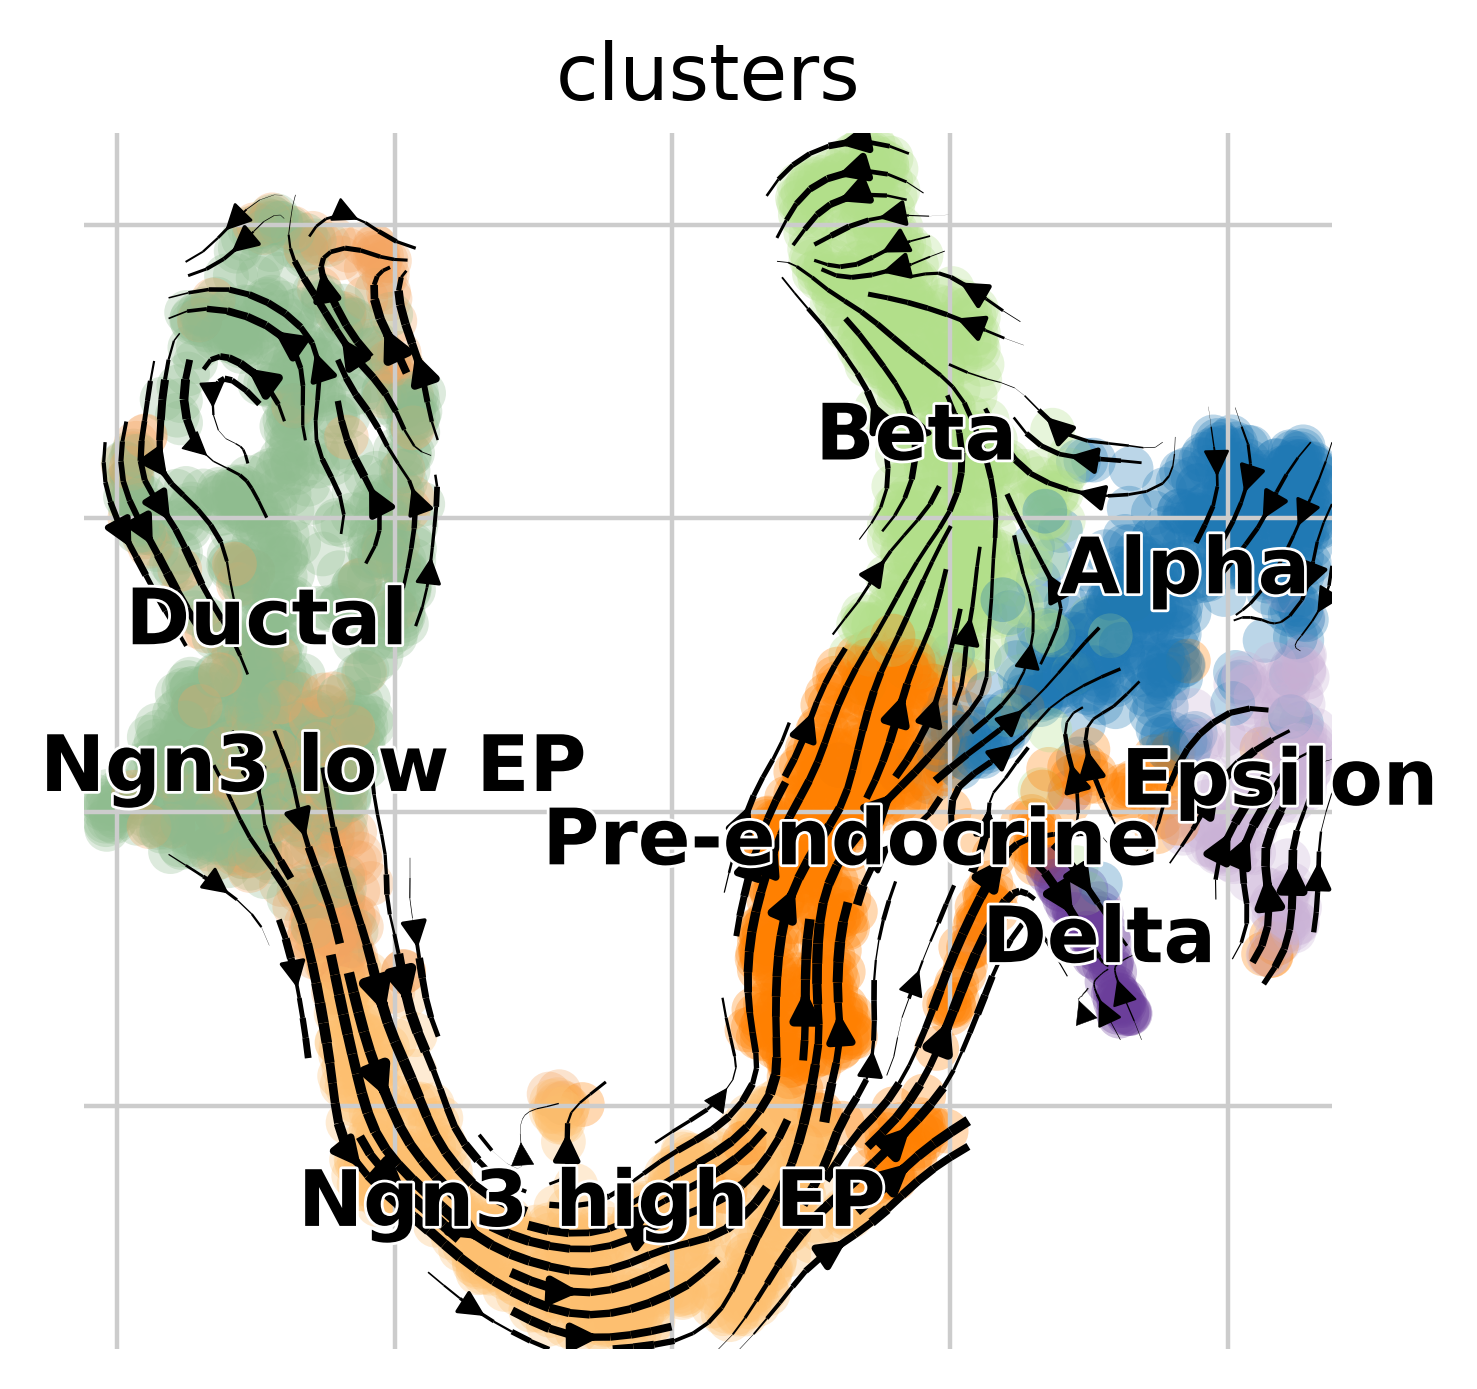

In [27]:
scv.pl.velocity_embedding_stream(adata, basis='umap', save="velocity_embedding")

/home/chels/thesis/repos/scvelo/scvelo/plotting/utils.py:866: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(smp, orientation=orientation, cax=cax)


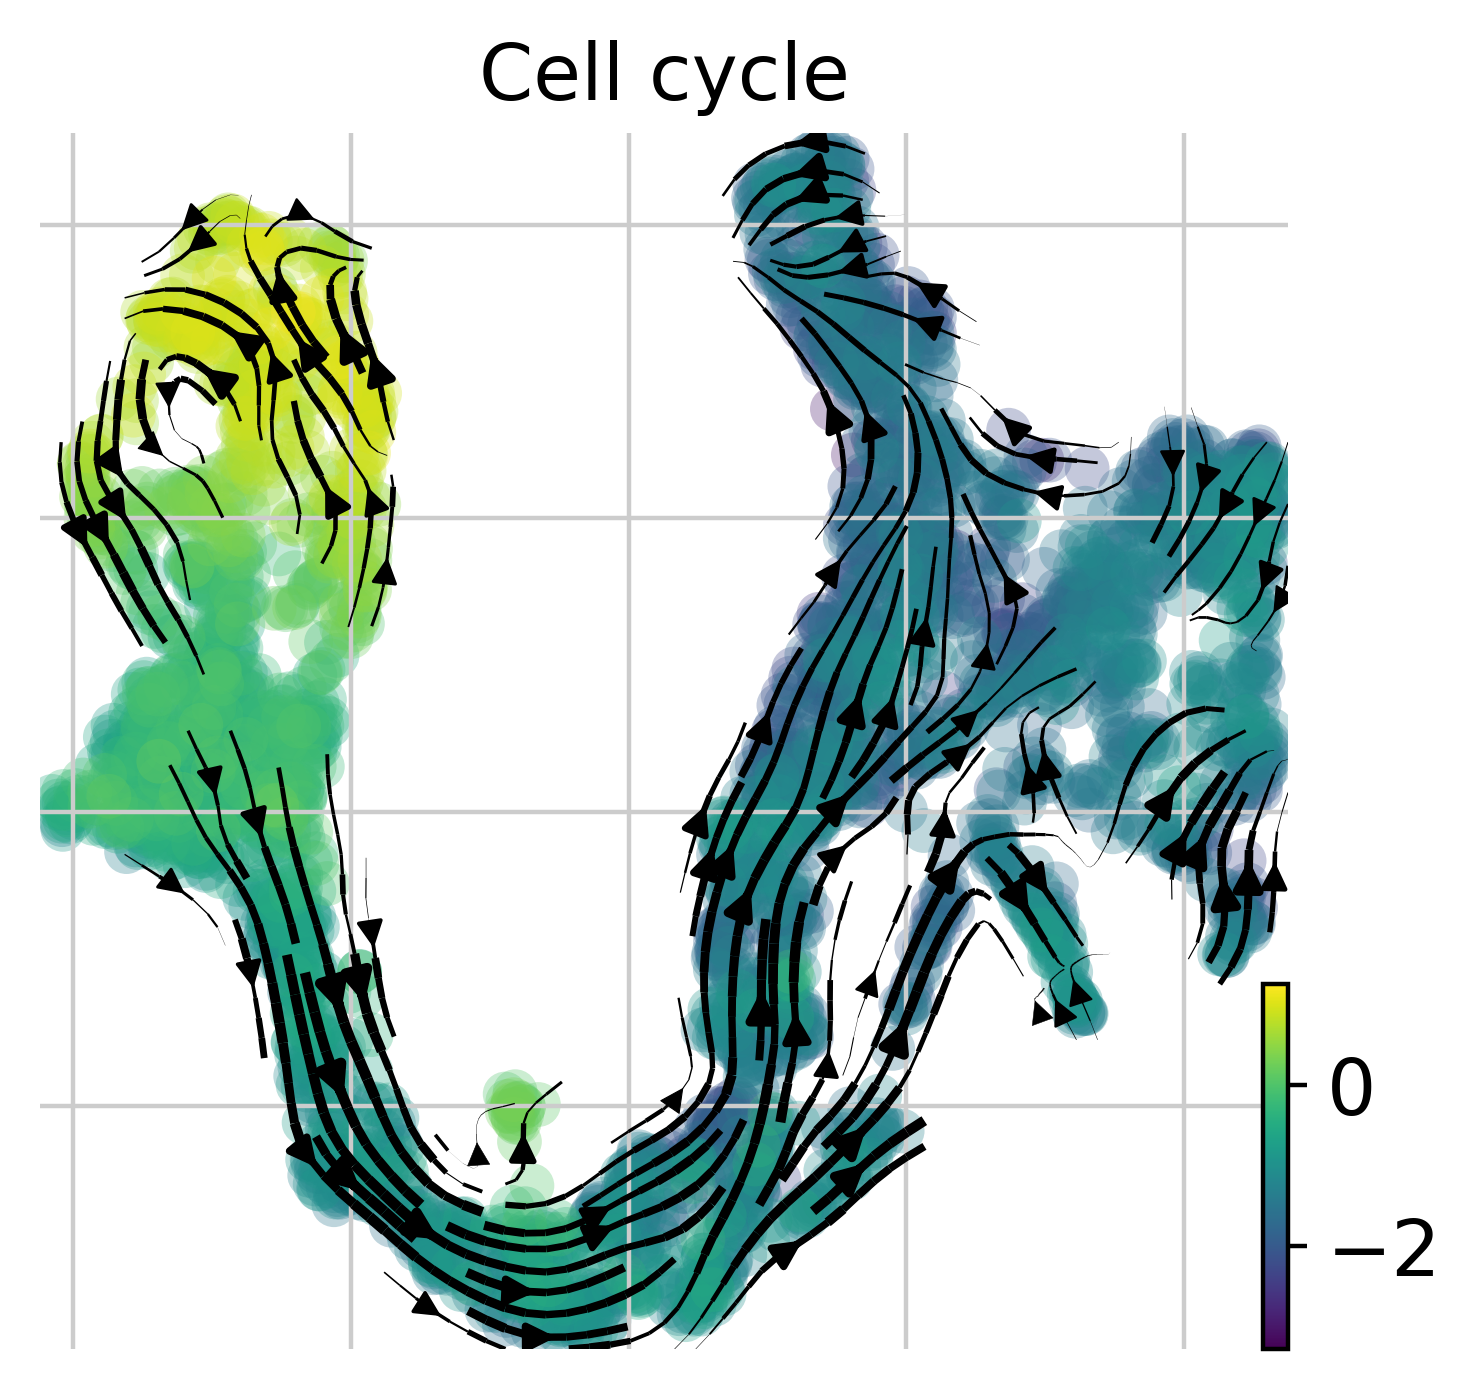

In [28]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color="CELL_CYCLE", title="Cell cycle")

In [ ]:
scv.pl.velocity_embedding_stream(ref_query, basis='umap', color="Regulation of Beta cell development")

Intrinsic uncertainty

In [19]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()

INFO     velovi: Sampling from model...                                                                            
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/an

directional_variance  directional_difference  \
index                                                            
AAACCTGAGAGGGATA              0.003387                0.182226   
AAACCTGAGCCTTGAT              0.005017                0.232567   
AAACCTGAGGCAATTA              0.004597                0.242510   
AAACCTGCATCATCCC              0.004714                0.210303   
AAACCTGGTAAGTGGC              0.004365                0.202090   

                  directional_cosine_sim_variance  \
index                                               
AAACCTGAGAGGGATA                         0.001933   
AAACCTGAGCCTTGAT                         0.002823   
AAACCTGAGGCAATTA                         0.002484   
AAACCTGCATCATCCC                         0.002611   
AAACCTGGTAAGTGGC                         0.002411   

                  directional_cosine_sim_difference  \
index                                                 
AAACCTGAGAGGGATA                           0.135782   
AAACCTGAGCCTTGAT                           0.175187   
AAACCTGAGGCAATTA                           0.179326   
AAACCTGCATCATCCC                           0.155247   
AAACCTGGTAAGTGGC                           0.148144   

                  directional_cosine_sim_mean  
index                                          
AAACCTGAGAGGGATA                     0.666899  
AAACCTGAGCCTTGAT                     0.657598  
AAACCTGAGGCAATTA                     0.677766  
AAACCTGCATCATCCC                     0.676280  
AAACCTGGTAAGTGGC                     0.676280

In [20]:
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)

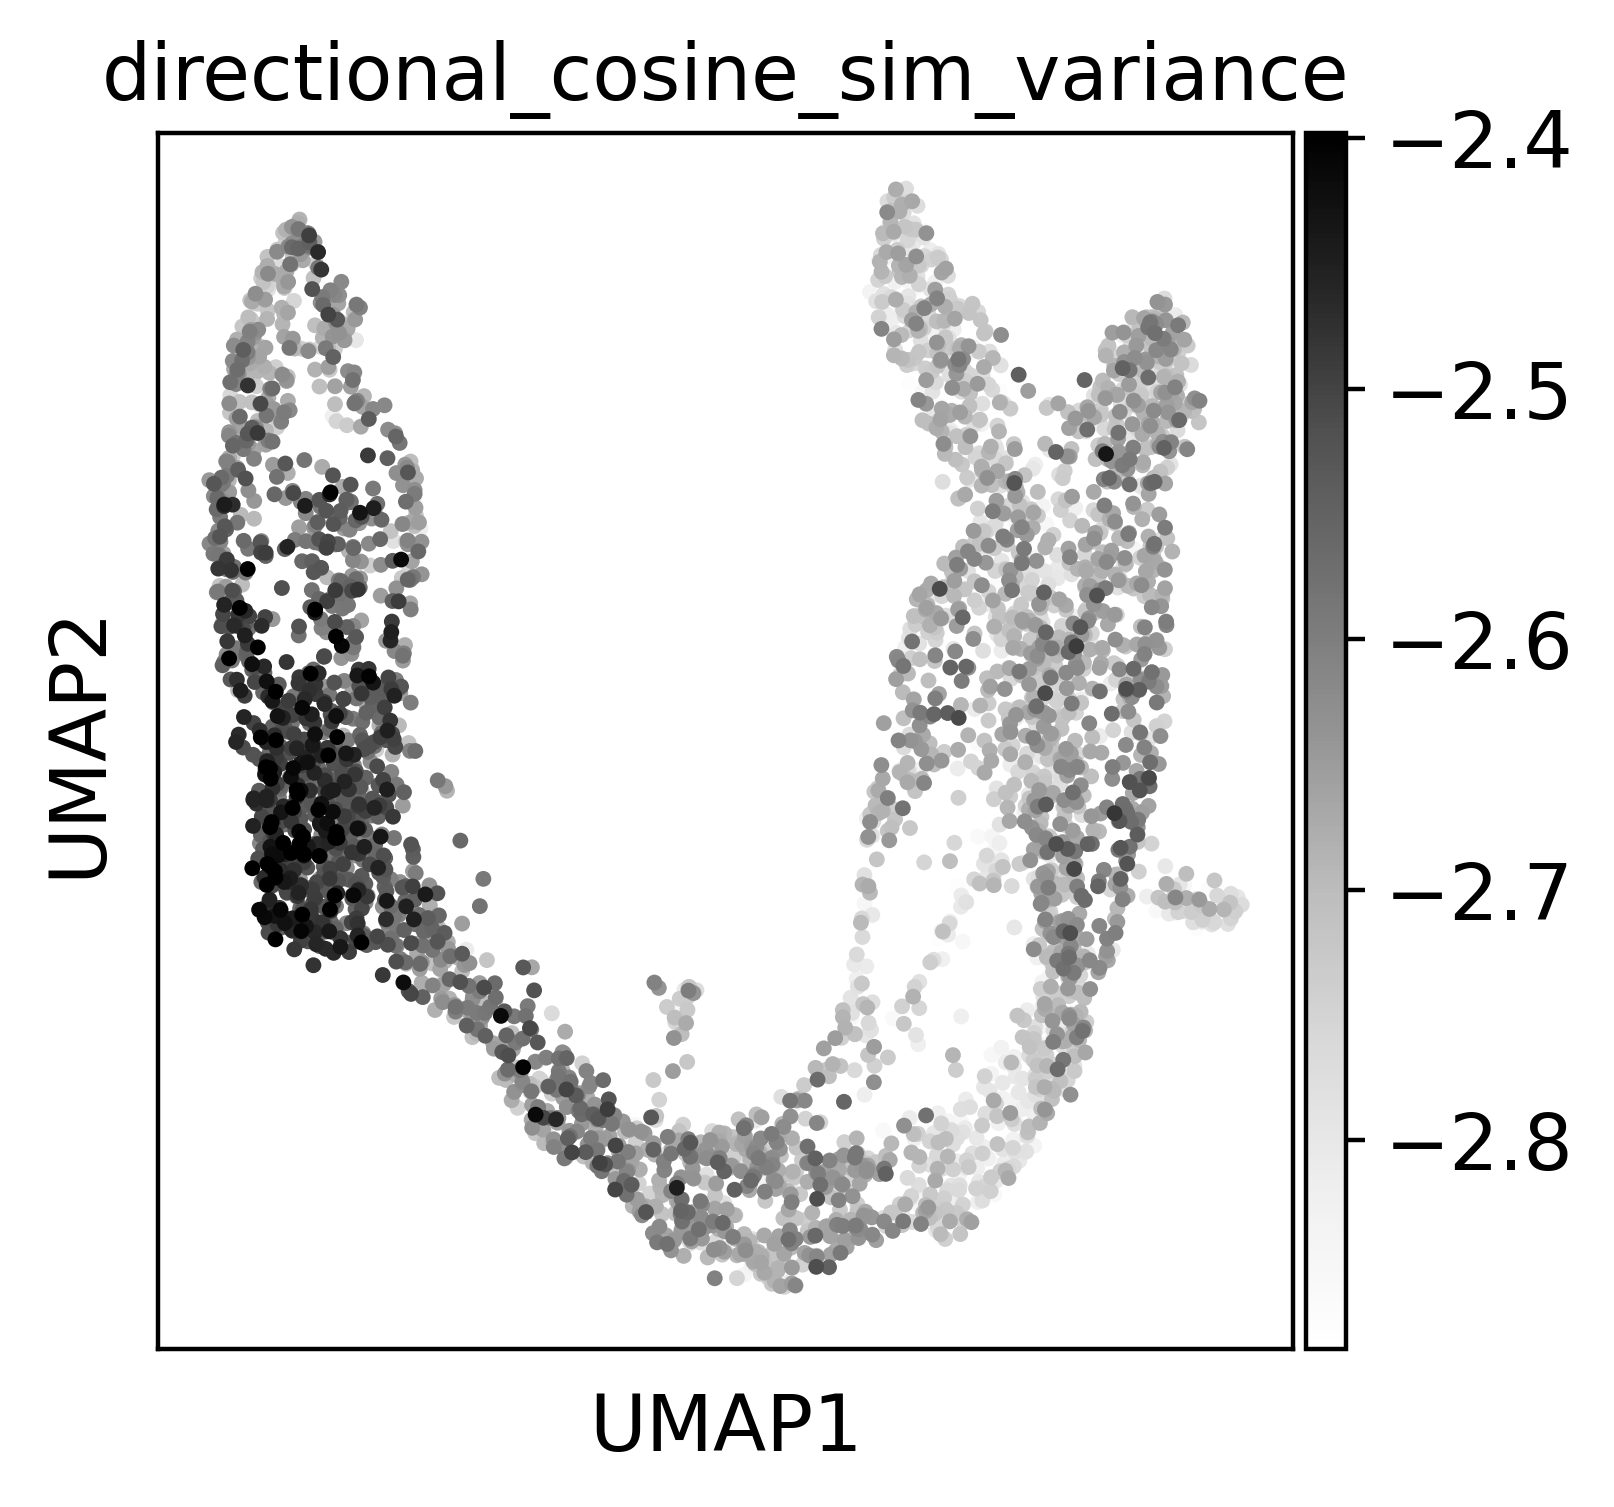

In [22]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99",
    save="intrinsic_uncertainty.png"
)

Extrinsic uncertainty

In [23]:
def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    from velovi._model import _compute_directional_statistics_tensor
    from scvi.utils import track
    from contextlib import redirect_stdout
    import io

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = "velocities_velovi_{i}".format(i=i)
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df

In [24]:
ext_uncertainty_df = compute_extrinisic_uncertainty(adata, vae)

Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [01:02<25:07, 62.83s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [01:21<14:07, 36.85s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [01:38<10:12, 27.83s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [01:55<08:15, 23.58s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [02:14<07:14, 21.74s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [02:32<06:31, 20.59s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [02:51<05:59, 19.99s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [03:09<05:32, 19.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [03:59<07:40, 28.81s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [04:15<06:14, 24.96s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [04:32<05:14, 22.44s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [04:48<04:27, 20.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [05:04<03:51, 19.27s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [05:20<03:21, 18.34s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [05:37<02:57, 17.71s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [05:54<02:39, 17.67s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [06:11<02:19, 17.41s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [06:52<02:52, 24.61s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [07:10<02:14, 22.40s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [07:27<01:44, 20.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [07:44<01:19, 19.76s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [08:02<00:57, 19.15s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [08:19<00:37, 18.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [08:35<00:17, 17.94s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [08:52<00:00, 21.31s/it]
INFO     velovi: Computing the uncertainties...                                                                    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/anaconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/chels/an

In [36]:
for c in ext_uncertainty_df[0].columns:
    adata.obs[c + "_extrinsic"] = np.log10(ext_uncertainty_df[0][c].values)

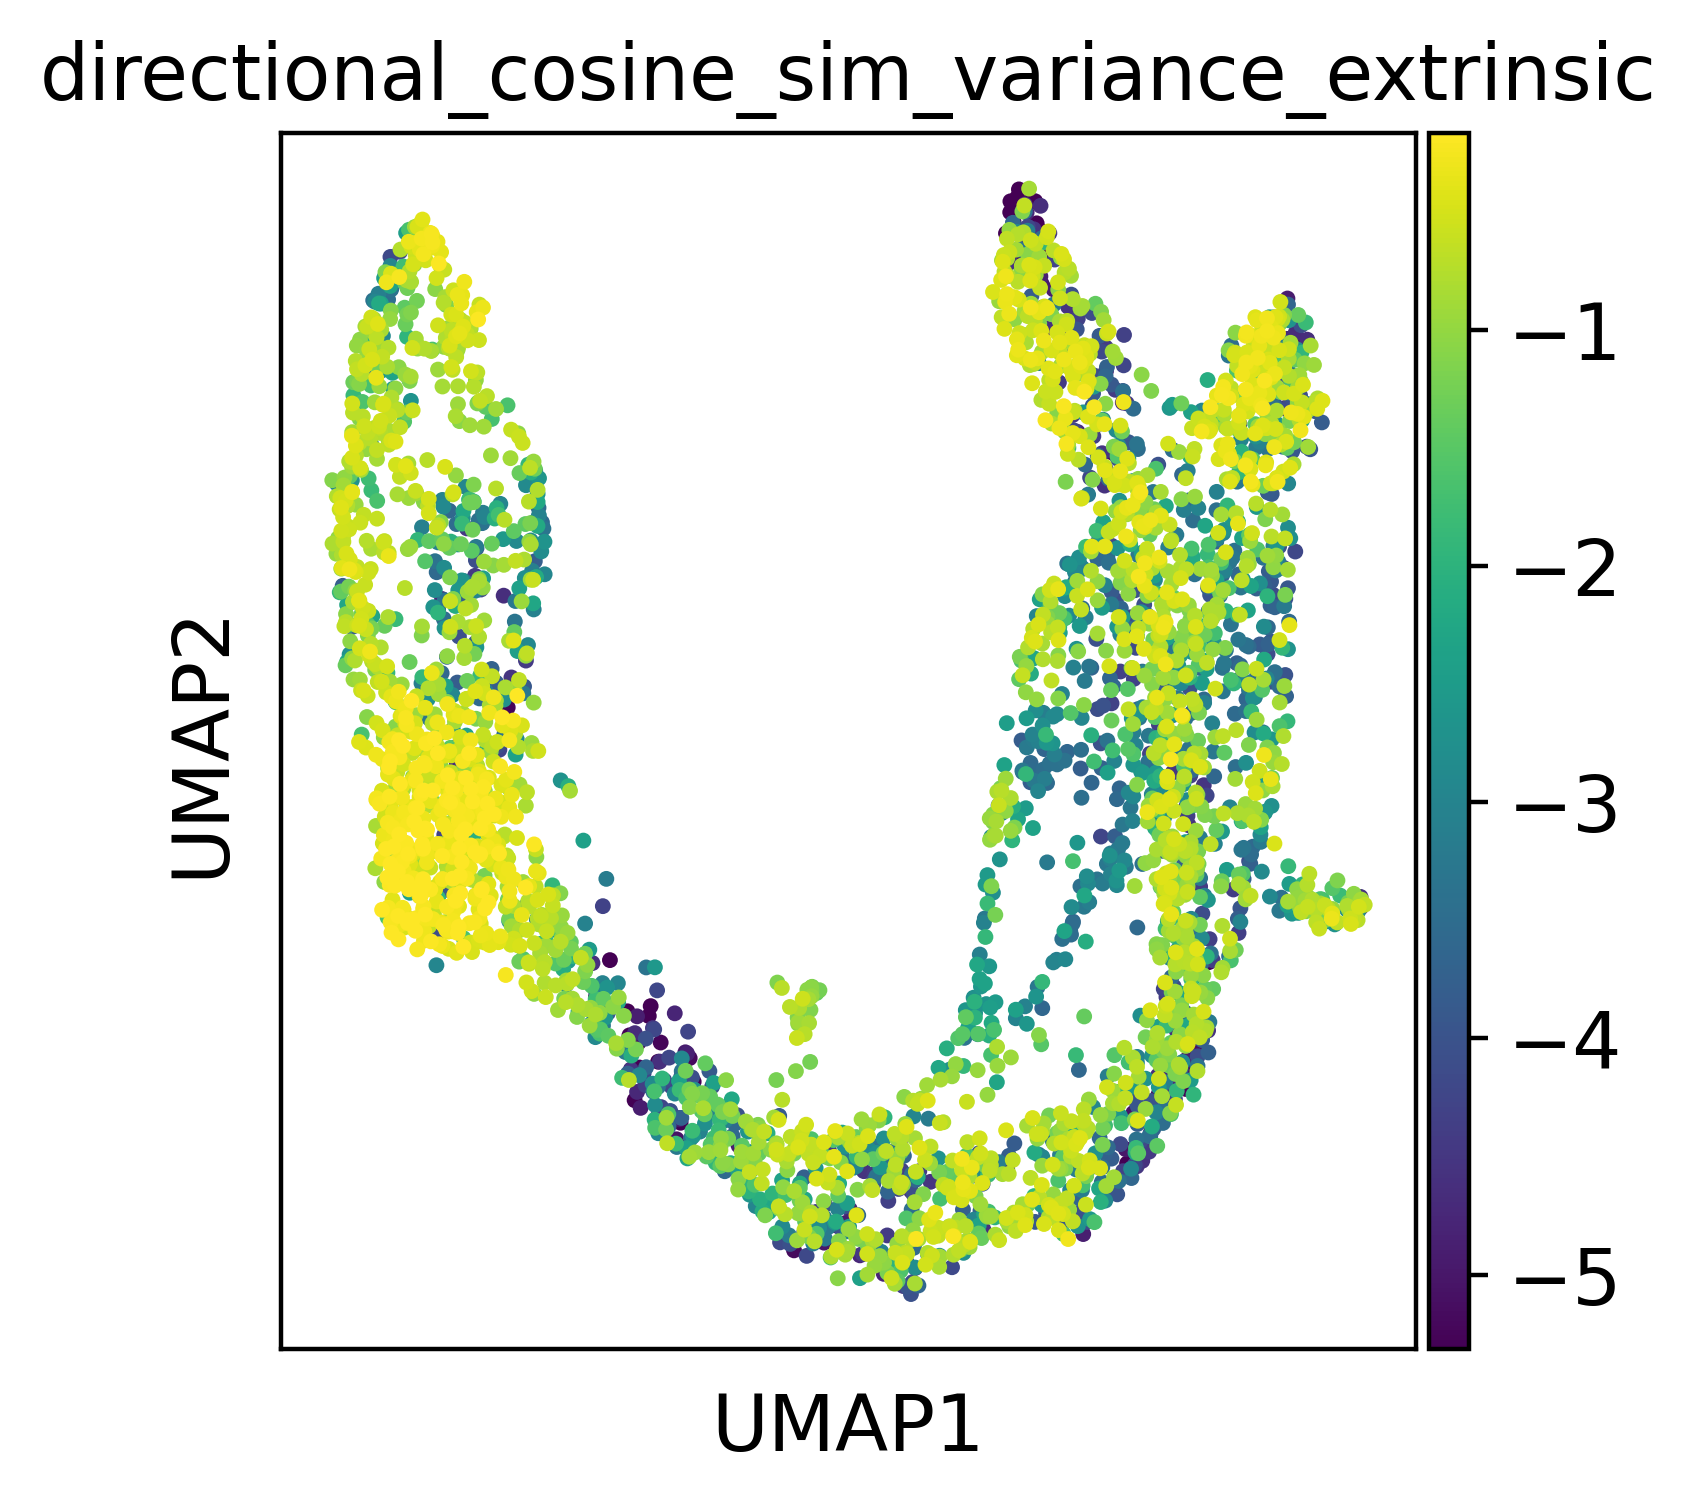

In [37]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance_extrinsic",
    vmin="p1", 
    vmax="p99", 
    save="extrinsic_uncertainty.png"
)

Permutation score

In [38]:
perm_df, _ = vae.get_permutation_scores(labels_key="clusters")
adata.var["permutation_score"] = perm_df.max(1).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


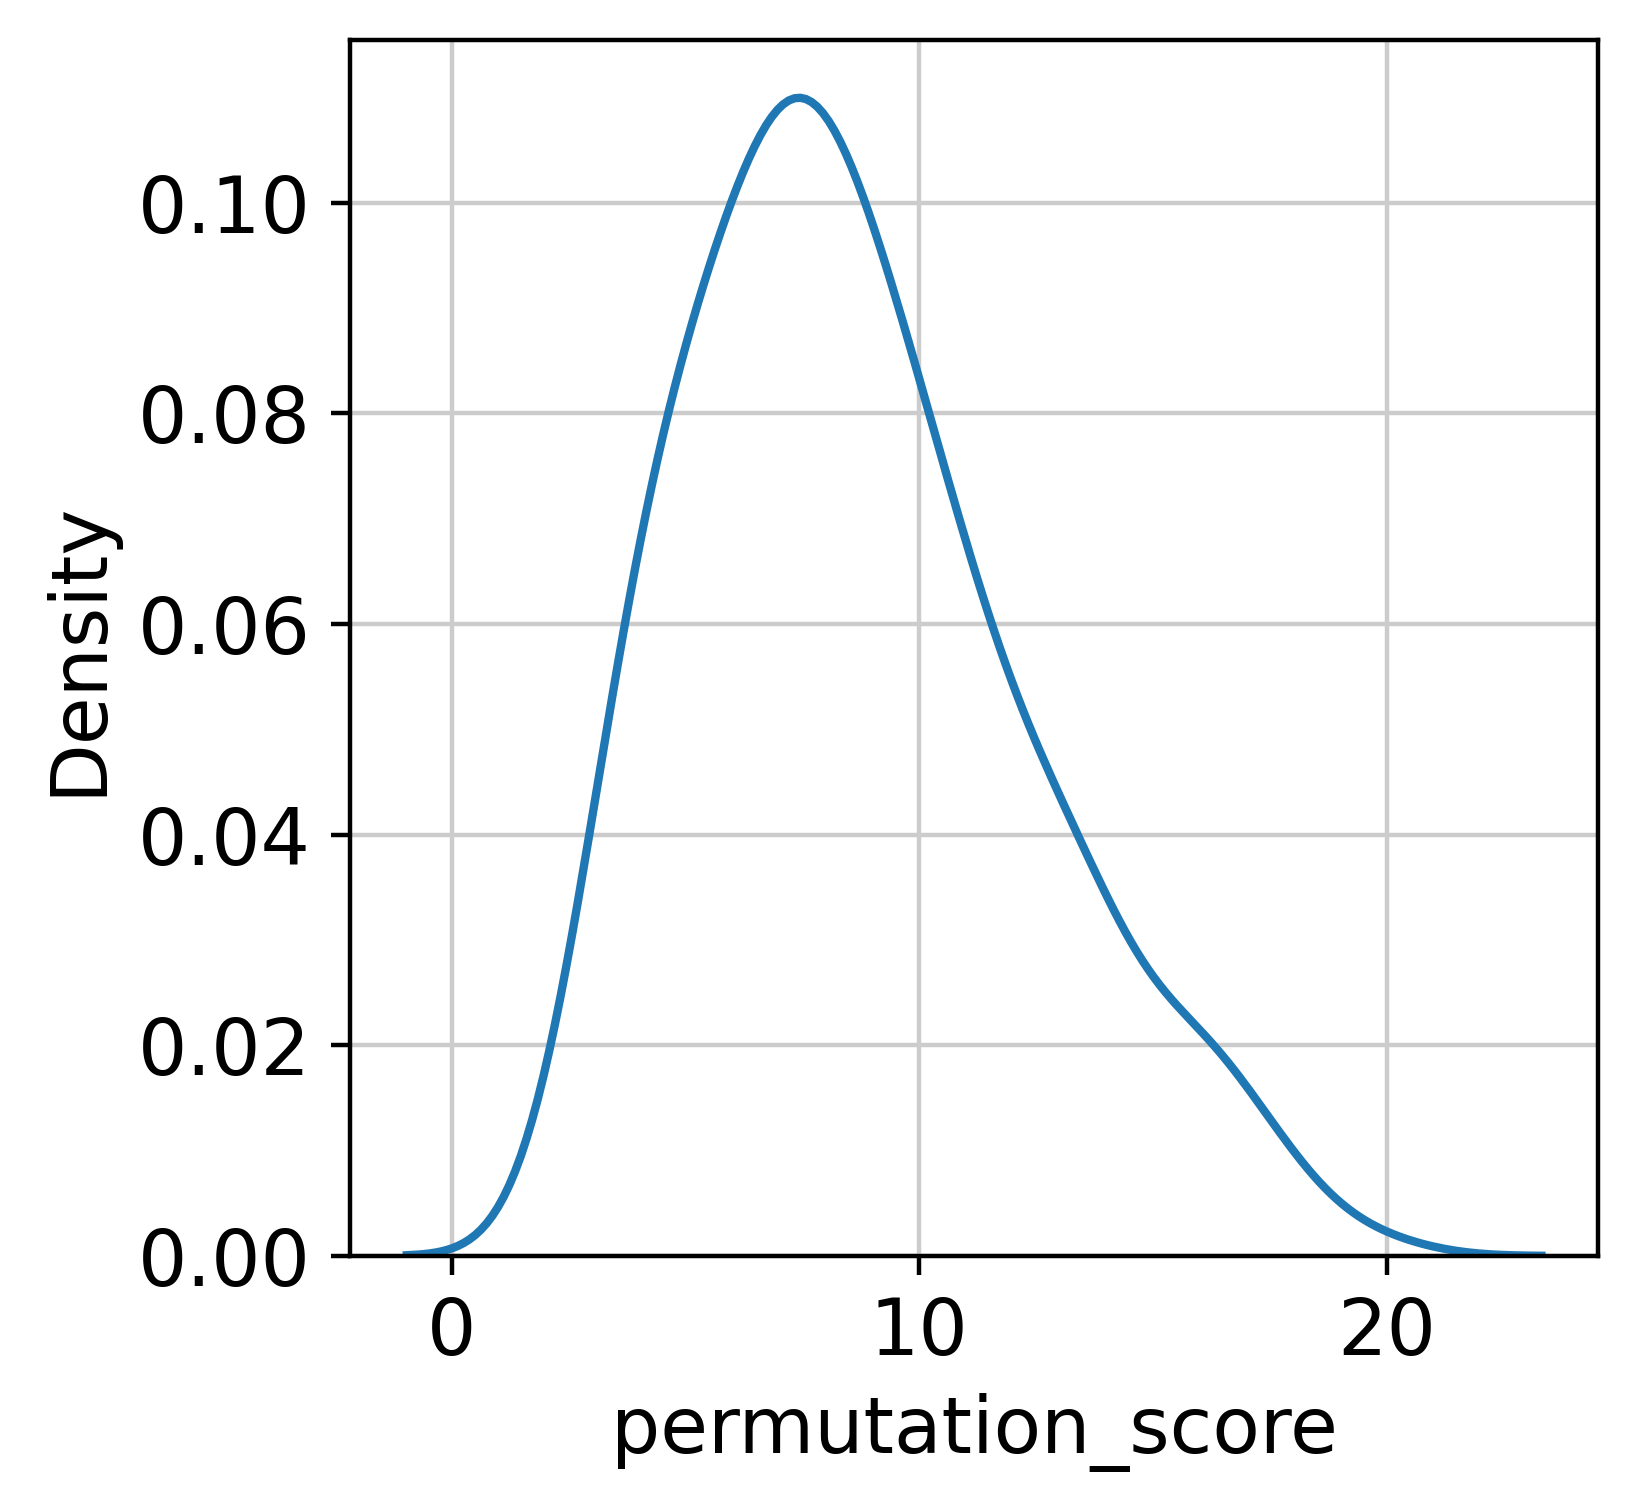

In [42]:
perm_score=sns.kdeplot(data=adata.var, x="permutation_score")
perm_score_fig=perm_score.get_figure()
perm_score_fig.savefig("figures/permutation_score.png") 

In [ ]:
#Sunday
#run without soft mask
#check if GPs are decreasing (look at GPs not included in original pancreas app to expimap)
#get latent directions
#plot GPs
#Compare with orig velovi

#Monday
#Apply other decoder
